# PyTorch implementation of feed-forward neural networks

## Import librairies

In [44]:
from importlib import reload

import path_imports
import src.classification.my_fnn_torch

reload(src.classification.my_fnn_torch)

import eli5
import gensim.downloader
import matplotlib.pyplot as plt
from eli5.lime import TextExplainer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split

from src.classification.my_fnn_torch import MyFnnTorch
from src.read_corpus import read_corpus

## Load pretrained Word2vec models

In [2]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
pretrained_wv = gensim.downloader.load('glove-wiki-gigaword-300')
print(pretrained_wv.most_similar('kevin'))
print(pretrained_wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1))

[('ryan', 0.5959905385971069), ('brian', 0.5930478572845459), ('anderson', 0.5515516400337219), ('murphy', 0.5254671573638916), ('sean', 0.5238237977027893), ('michael', 0.5100076794624329), ('smith', 0.5093246102333069), ('chris', 0.49988123774528503), ('kelly', 0.49805787205696106), ('jeff', 0.49499109387397766)]
[('queen', 0.6713277101516724)]


## Load dataset and split dataset

### Load

In [27]:
dfp = read_corpus(categories=["tweet"], presidents=["Barack Obama", "Donald Trump", "Joe Biden"])
dfp

100%|██████████| 29/29 [00:03<00:00,  8.62it/s]


,category,name,date,text
0,tweet,Donald Trump,2011-08-02 18:07:48,Republicans and Democrats have both created ou...
1,tweet,Donald Trump,2020-03-03 01:34:50,I was thrilled to be back in the Great city of...
2,tweet,Donald Trump,2020-09-12 20:10:58,The Unsolicited Mail In Ballot Scam is a major...
3,tweet,Donald Trump,2020-02-01 16:14:02,Getting a little exercise this morning! https:...
4,tweet,Donald Trump,2020-10-23 04:52:14,https://t.co/4qwCKQOiOw
...,...,...,...,...
6032,tweet,Joe Biden,2020-11-01 11:40,"As president, I’ll build an economy that rewar..."
6033,tweet,Joe Biden,2020-11-01 12:01,Let’s put dogs back in the White House. https:...
6034,tweet,Joe Biden,2020-11-01 12:20,We have in our hands the ultimate power: the p...
6035,tweet,Joe Biden,2020-11-01 12:40,"We need to:\n\nBuild bridges, not walls.\nOpen..."


## Split

In [28]:
X = dfp["text"]
y = dfp["name"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, y_train.shape

((47665,), (47665,))

## Feed-forward neural network with torch

### Load the model

In [114]:
model = MyFnnTorch(num_classes=3, word2vec=pretrained_wv, nb_epochs=3)

### Train the model

In [115]:
model.fit(X_train, y_train, X_test, y_test)

Epoch [1/3], Loss: 0.0909
Precision: 0.9199, Recall: 0.9215, F1 Score: 0.9206
Epoch [2/3], Loss: 0.2136
Precision: 0.9188, Recall: 0.9175, F1 Score: 0.9149
Epoch [3/3], Loss: 0.2729
Precision: 0.9302, Recall: 0.9296, F1 Score: 0.9298


### Prediction

In [64]:
text = dfp[dfp["name"] == "Donald Trump"].iloc[0]["text"]
print(text)
model.predict([text])

Republicans and Democrats have both created our economic problems.


array(['Donald Trump'], dtype=object)

## Evaluation

### Table (precision, recall, f1-score)

In [105]:
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

Barack Obama       0.86      0.83      0.85      1362
Donald Trump       0.95      0.98      0.96      9345
   Joe Biden       0.84      0.65      0.74      1210

    accuracy                           0.93     11917
   macro avg       0.88      0.82      0.85     11917
weighted avg       0.93      0.93      0.93     11917



### Confusion Matrix

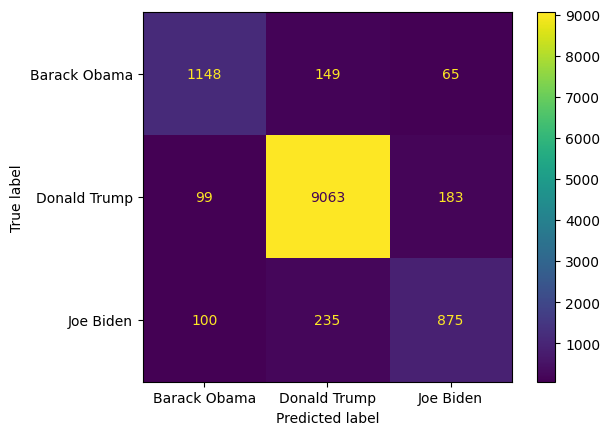

In [33]:
cm = confusion_matrix(y_test, y_pred, labels=model.label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.label_encoder.classes_)
disp.plot()
plt.show()

## Explicability

In [106]:
dfp["pred"] = model.predict(X)

In [113]:
dfp2 = dfp.copy()
if False:
    true_label = "Barack Obama"
    pred_label = "Donald Trump"
    dfp2 = dfp2[dfp2["name"] == true_label]
    dfp2 = dfp2[dfp2["pred"] == pred_label]

if True:
    dfp2 = dfp2[dfp2["text"].str.contains("congrats")]

print(dfp2.shape)
sample = dfp2.iloc[0]
text = sample["text"]
name = sample["name"]
text, name

dfp2.shape

(35, 5)


,category,date,text,pred
name,,,,
Barack Obama,2,2,2,2
Donald Trump,31,31,31,31
Joe Biden,2,2,2,2


In [109]:
te = TextExplainer(random_state=42, n_samples=5000)
te.fit(text, lambda X : model.predict_proba(X).detach().numpy())
te.show_prediction(target_names=model.label_encoder.classes_.tolist())

/home/secouss/repos/nlp-usa-presidents/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/secouss/repos/nlp-usa-presidents/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [104]:
te.metrics_

{'mean_KL_divergence': 0.03386734930533107, 'score': 1.0}

In [ ]:
# des samples ou finalement il n'y a rien pour bien prédire, c'est le bias qui prend le dessus 
# congrats --> Donald Trump
